### Load libraries and functions

In [1]:
#Load libraries
library(Seurat)
library(stringr)
library(viridis)
library(ggplot2)
library(cowplot)
library(cluster)
library(data.table)
library(foreach)
library(doParallel)
library(proxy)
library(ComplexHeatmap)
library(circlize)
library(igraph)
library(qvalue)
library(dplyr)
library(viridis)
library(VGAM)
library(forcats)
library(grDevices)
library(graphics)
library(RColorBrewer)
library(pheatmap)
library(Cairo)
library(reshape2)
library(R.utils)
library(Rcpp)
library(parallelDist)
library(ggsci)
library(scales)
set.seed(seed = 42)
library(ADTnorm)
library(clusterProfiler)
library(org.Hs.eg.db)
library(msigdbr)
library(ggrepel)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Loading required package: viridisLite

Loading required package: iterators

Loading required package: parallel


Attaching package: ‘proxy’


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo

In [2]:
#load basic functions
createEmptyDf = function( nrow, ncol, colnames = c() ){
  data.frame( matrix( vector(), nrow, ncol, dimnames = list( c(), colnames ) ) )
}

tableread_fast = function(i, header=TRUE, quote="", sep=","){
  tmp = fread(i, header=header, sep=sep, quote=quote, nThread=32)
  tmp = as.data.frame(tmp)
  return(tmp)
}

In [3]:
#Stacked Violin Plot
#https://divingintogeneticsandgenomics.rbind.io/post/stacked-violin-plot-for-visualizing-single-cell-data-in-seurat/

## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          plot.title= element_blank(),
          axis.title.x = element_blank(),
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(family = "Arial", size = 6, angle = 0, colour = "black", face = "plain"), 
          axis.text.y = element_blank(), 
          plot.margin = plot.margin ) 
  return(p)
}
## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}
## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.05, 0, -0.05, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(family = "Arial", size=8, face = "plain"),
          axis.ticks.x = element_line())
  
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))
  
  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1, heights = 1)
  return(p)
}

In [4]:
###Define function
##Plotting Signature scores for clusters
vlnplot_score_box <- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  p<- VlnPlot(obj, features = feature, pt.size = pt.size)  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    ggplot2::geom_boxplot(outlier.size = 0, size = 0.2) + 
    theme(legend.position = "none",
          plot.title= element_blank(),
          axis.title.x = element_blank(),
          axis.text.x =  element_text(family = "Arial", size = 8, angle = 0, colour = "black", face = "plain"), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_blank(), 
          axis.text.y = element_text(family = "Arial", size = 6, angle = 0, colour = "black", face = "plain"), 
          plot.margin = plot.margin ) 
  return(p)
}

In [5]:
##Plot clones in dimentional reduction plot (DimPlot)
#seu: Seurat object / tmp2: identifier of plotting cells

PlotClones = function(seu, tmp2, name.output, meta.data, reduction, width, height, size){
    #Exctract names for cells in plot
    tmp_raw <- as.vector(row.names(meta.data))
    #Extract colors for plot
    p2 = Seurat::DimPlot(object = seu, reduction = reduction, pt.size = 0.1)
    orig_ident_build = ggplot2::ggplot_build(p2)
    orig_ident_build = orig_ident_build$data[[1]]
    orig_ident_build =  orig_ident_build[order(orig_ident_build$group), ]
    ident.cols = unique(orig_ident_build$colour) # Get a vector of unique colors
    names(ident.cols)=c(0:(max(as.numeric(seu@active.ident)-1)))

    #Extract x- and y- axis information for DimPlot
    xmin <- min(orig_ident_build$x)-0.5
    xmax <- max(orig_ident_build$x)+0.5
    ymin <- min(orig_ident_build$y)-0.5
    ymax <- max(orig_ident_build$y)+0.5
    x_label_min <- floor(xmin/10)*10
    x_label_max <- ceiling(xmax/10)*10
    y_label_min <- floor(ymin/10)*10
    y_label_max <- ceiling(ymax/10)*10

    #Dimplot
    p1 <- DimPlot(object = seu, label = FALSE,
                    cells = tmp2,
                    reduction = reduction,
                    cols = ident.cols,
                    pt.size = size) + 
        NoLegend() +
        scale_x_continuous(limits = c(xmin,xmax), breaks= seq(x_label_min,x_label_max,10)) +
        scale_y_continuous(limits = c(ymin,ymax), breaks= seq(y_label_min,y_label_max,10)) +
        theme(axis.title = element_blank(), 
              axis.text = element_blank(),
             axis.line = element_line(size = 0.4))
    
      save_plot(file = name.output, plot_grid(p1, ncol=1, nrow=1), device="tiff", 
                units="in", dpi = 300, base_width = width, base_height = height, limitsize=FALSE)
}

In [6]:
##Main functions
#Summarize pattern distribution
Dist_summarize = function(file.name, dir.input){
    #load
    name.input <- str_c(dir.input, file.name, sep = "/")
    d <- tableread_fast(name.input, header = TRUE, quote="\"", sep=",")
  
    #IncとRespをまとめる
#    d$Resp <- str_remove(d$Resp, "Inc")
    
    out.table <- data.frame()
    #Prepare data frame
    d_sub2 <- dplyr::select(d, contains("X"))
    d_param <- dplyr::select(d, "Resp")
    d_sub2$class <- d_param$Resp
    
    #Summarize
    table <- group_by(d_sub2, class) %>% summarise(dplyr::across(starts_with("X"), sum))
    out.table <- rbind(out.table, table)
    out.table$file.name <- file.name 
    
    return(out.table)
}

In [7]:
###Plot bar graph for cluster distribution
Cluster_bar <- function(seu, red.use, data, dir.name, file.name, width, height){
    #Extract colors for plot
    p2 = Seurat::DimPlot(object = seu, reduction = red.use, pt.size = 0.1)
    orig_ident_build = ggplot2::ggplot_build(p2)
    orig_ident_build = orig_ident_build$data[[1]]
    orig_ident_build =  orig_ident_build[order(orig_ident_build$group), ]
    ident.cols = unique(orig_ident_build$colour) # Get a vector of unique colors
    names(ident.cols)=c(0:(max(as.numeric(seu@active.ident)-1)))

    #Plot bar graph
    ppi <- 600
     g <- ggplot(data, aes(x = Treat, y = Number, fill = clust)) +
        scale_fill_manual(values=ident.cols) +
        geom_bar(stat = "identity", position = "fill") +
        labs(y="Proportion of cluster") +
        scale_y_continuous(labels = percent) +
        theme_classic() + 
        theme(plot.title = element_blank(), 
              panel.background = element_rect(fill = "transparent",color = NA),
              plot.background = element_rect(fill = "transparent",color = NA),
                axis.title.x = element_blank(), 
                axis.title.y = element_text(size=8, colour = 1, family = "Arial"), 
                axis.text.x = element_blank(), 
                axis.text.y = element_text(size = 6, colour = 1, family = "Arial")) +
        guides(fill = "none") 
    save_plot(file = file.name, plot(g), device="tiff", 
              units="in", dpi = 300, base_width = width, base_height = height, limitsize=FALSE)
}

In [8]:
load("result/intermediate/2_SCT/COVID_ADTnorm_RPCA.wnn_3rd.res.0.2.wo-min.scTCR.Sig.rda")

### Figure 3: Single-cell analysis on CD8+ T cells

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


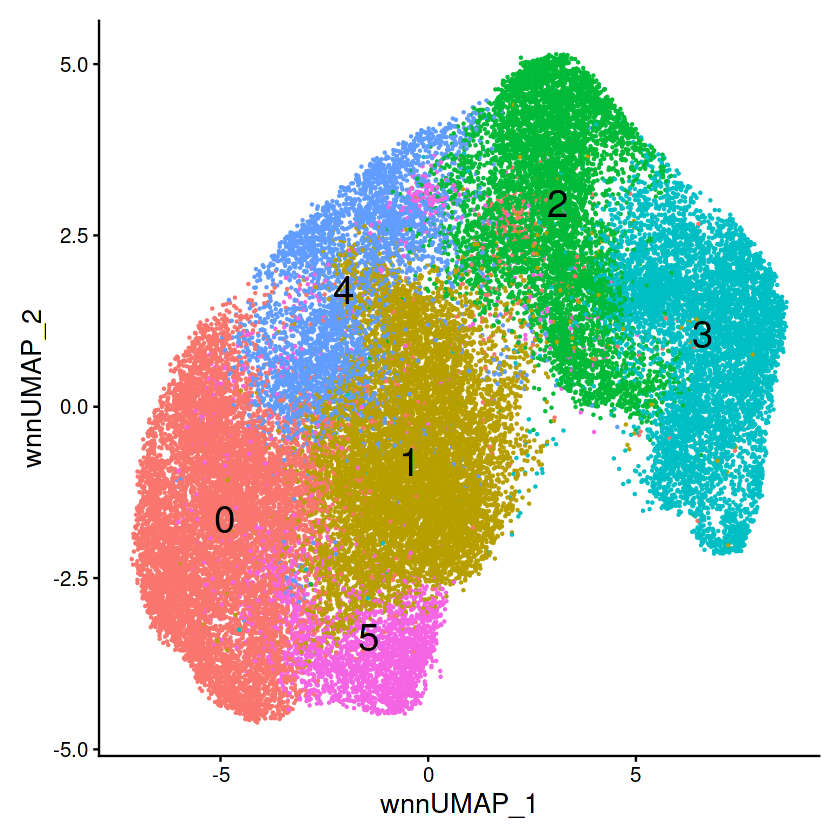

In [11]:
###Figure 2B, Protting the result of dimentional reduction

dir.name <- "result/Fig2"
file.name <- "2B.wnn.umap.tiff"

################################# Processing layer ##########################################
dir.create(dir.name, recursive = TRUE)

#Output twice size of figure, compress after pasting in the powerpoint.
p1 = DimPlot(object = seu, reduction = "wnn.umap", label = TRUE, label.size = 8, pt.size = 0.2) +
  theme(axis.title.x = element_text(size=16, family = "Arial"), 
        axis.title.y = element_text(size=16, family = "Arial"), 
        axis.text.x = element_text(size=12, colour = 1, family = "Arial"), 
        axis.text.y = element_text(size = 12, colour = 1, family = "Arial")) +
  theme(panel.border = element_rect(fill = NA, size = 1.5)) 

p1 = p1 + theme(legend.position = 'none')
name.output <- str_c(dir.name, file.name, sep = "/")
save_plot(file = name.output, plot(p1), device="tiff", 
          units="in", dpi = 300, base_width = 4.6, base_height = 4.6, limitsize=FALSE)

Warning message in dir.create(dir.name):
“'result/Fig2' already exists”


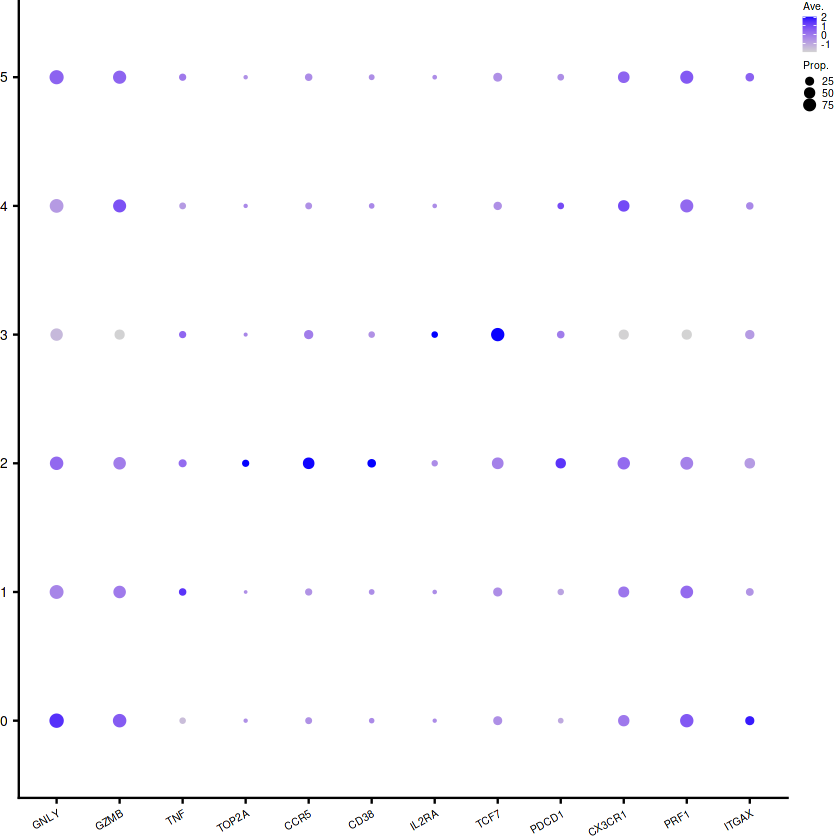

null device 
          1

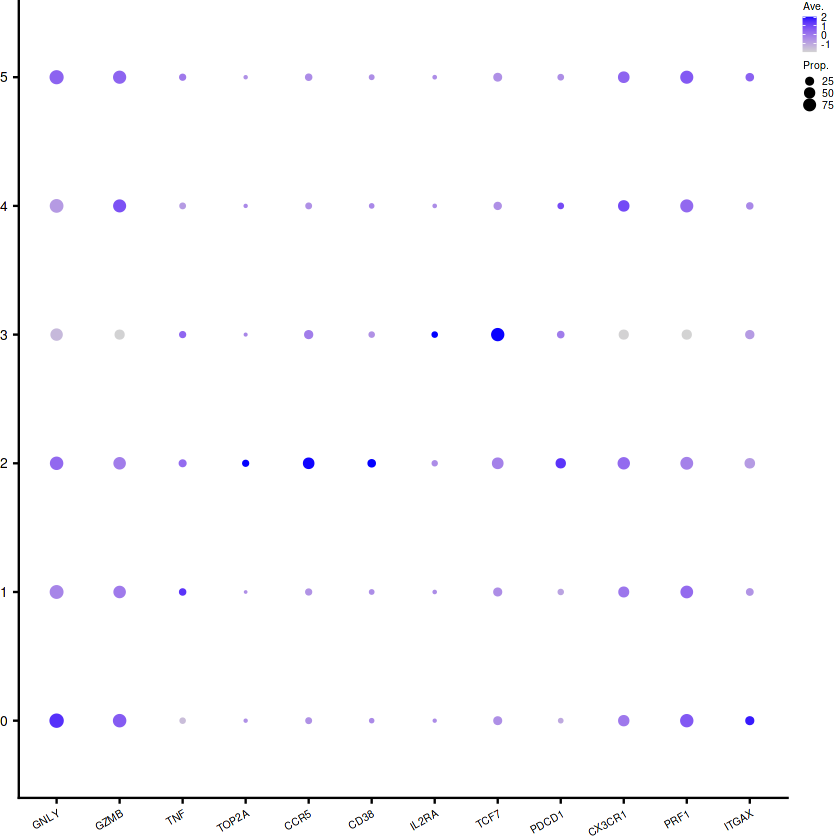

In [12]:
###Figure 2C, Baloon plot for RNA marker genes

dir.name <- "result/Fig2"
sample.name <- "Fig2C.RNA.BaloonPlot.tiff"
genes <- c("GNLY", "GZMB", "TNF", "TOP2A", "CCR5", "CD38", "IL2RA", "TCF7", "PDCD1", "CX3CR1", "PRF1", "ITGAX")

#breaks for legend color bar
bar <- c(-1, 0, 1, 2)

################################# Processing layer ##########################################
dir.create(dir.name)
    
DefaultAssay(seu) <- 'RNA.RPCA'
ppi <- 300
p <- DotPlot(seu, features = genes, cols = c("lightgrey", "blue"),
            dot.min = 0, dot.scale = 3,
            scale.by = "size", scale.min = NA, scale.max = NA) +
      theme(axis.title = element_blank(), 
            axis.text.y = element_text(size=8, colour = 1, family = "Arial"),
            axis.text.x = element_text(size=6, colour = 1, family = "Arial", angle = 30, hjust = 1)) + 
#        scale_colour_continuous(breaks =bar) +
      theme(panel.border = element_rect(fill = NA, size = 0.1),
            legend.position = "right",
            legend.key.width = unit(0.3, "cm"),
            legend.key.height = unit(0.15, "cm"),
            legend.justification = "top",
            legend.text = element_text(size=6, colour = 1, family = "Arial"),
            legend.title = element_text(size=6, colour = 1, family = "Arial"),
            legend.margin=margin(0,0,-10,0),
            legend.box.margin=margin(0,5,15,-5),
            plot.margin = unit(c(0, 0, 0, 0), "cm")) +
        guides(colour = guide_colourbar(order=1, breaks=seq(-2,2,1)),
               size = guide_legend(order=2))
p$guides$colour$title <- "Ave."
p$guides$size$title <- "Prop."
file.name <- str_c(dir.name, sample.name, sep="/")
save_plot(file = file.name, plot(p), device="tiff", 
              units="in", dpi = 600, base_width = 3.8, base_height = 1, limitsize=FALSE)
plot(p)
dev.off()


Warning message in dir.create(dir.name):
“'result/Fig2' already exists”


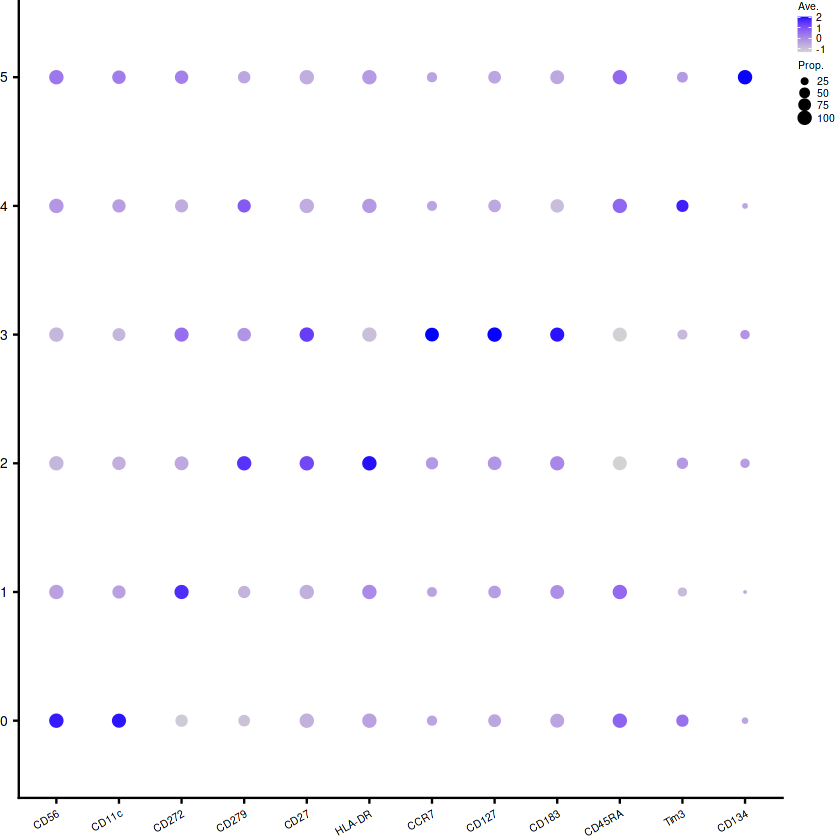

null device 
          1

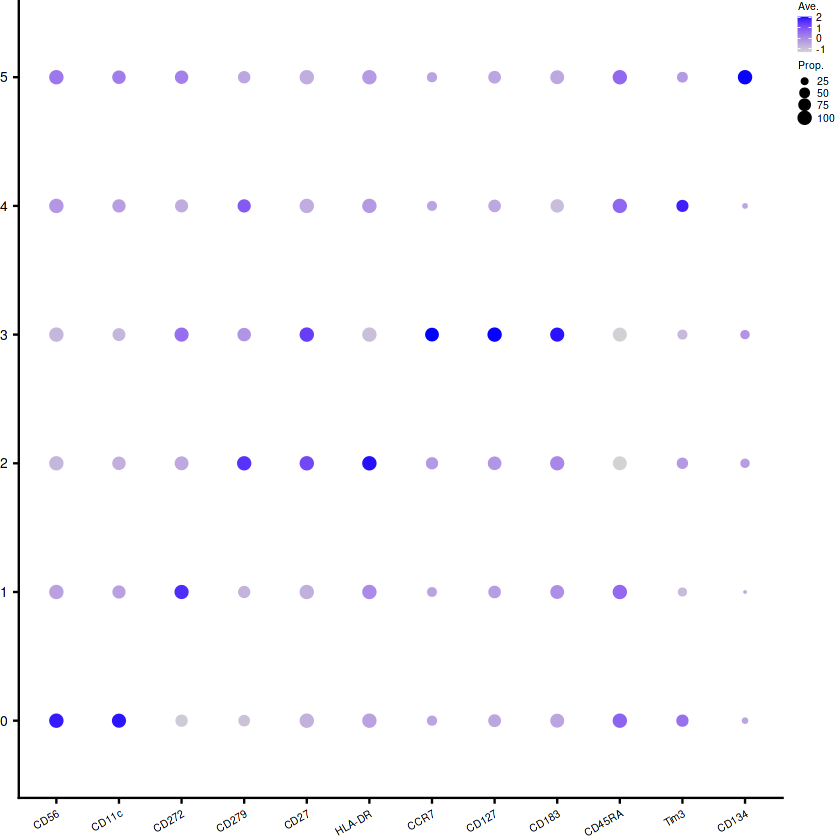

In [13]:
###Figure 2D, Baloon plot for ADT marker genes

dir.name <- "result/Fig2"
sample.name <- "Fig2D.ADT.BaloonPlot.tiff"
genes <- c("CD56", "CD11c", "CD272", "CD279", "CD27", "HLA-DR", "CCR7", "CD127", "CD183", "CD45RA", "Tim3", "CD134")

#breaks for legend color bar
bar <- c(-1, 0, 1, 2)

################################# Processing layer ##########################################
dir.create(dir.name)
    
DefaultAssay(seu) <- 'ADT'
ppi <- 300
name.output <- str_c(dir.name, file.name, sep = "/")
p <- DotPlot(seu, features = genes, cols = c("lightgrey", "blue"),
            dot.min = 0, dot.scale = 3,
            scale.by = "size", scale.min = NA, scale.max = NA) +
      theme(axis.title = element_blank(), 
            axis.text.y = element_text(size=8, colour = 1, family = "Arial"),
            axis.text.x = element_text(size=6, colour = 1, family = "Arial", angle = 30, hjust = 1)) + 
#        scale_colour_continuous(breaks =bar) +
      theme(panel.border = element_rect(fill = NA, size = 0.1),
            legend.position = "right",
            legend.key.width = unit(0.3, "cm"),
            legend.key.height = unit(0.15, "cm"),
            legend.justification = "top",
            legend.text = element_text(size=6, colour = 1, family = "Arial"),
            legend.title = element_text(size=6, colour = 1, family = "Arial"),
            legend.margin=margin(0,0,-10,0),
            legend.box.margin=margin(0,5,15,-5),
            plot.margin = unit(c(0, 0, 0, 0), "cm")) +
        guides(colour = guide_colourbar(order=1, breaks=seq(-2,2,1)),
               size = guide_legend(order=2))
p$guides$colour$title <- "Ave."
p$guides$size$title <- "Prop."
file.name <- str_c(dir.name, sample.name, sep="/")
save_plot(file = file.name, plot(p), device="tiff", 
              units="in", dpi = 600, base_width = 3.8, base_height = 1, limitsize=FALSE)
plot(p)
dev.off()


In [16]:
#Figure 2E: Plot cells on clusters by response patterns (all)

dir.name <- "result/Fig2/2E"
dir.input <- "result/intermediate/2_SCT/scTCR_analysis" #Directory for clone table of scTCR
red.use <- "wnn.umap" #dimentional reduction used
patterns <- c("Early", "Main")
groups <- c("Early_TP3", "Main_TP3", "Main_TP8")

##################### Processing layer #############################################################
dir.create(dir.name, recursive = TRUE)

#Load meta data
meta.data <- as.data.frame(seu@meta.data)
tmp_raw <- as.vector(row.names(meta.data))

sct.names <- list.files(dir.input, "bulkinfo.csv")

data_Resp <- data.frame()
data_RespInc <- data.frame()
TPs <- unique(meta.data$TP)

for(TP in TPs){
    sct.names.sub <- sct.names[str_detect(sct.names, TP)]
    for(pattern in patterns){
    data_Resp <- data.frame()
        for(sct.name in sct.names.sub){
            #Call clone table
            clone_within_cluster <- read.csv(str_c(dir.input, sct.name, sep = "/"), header = TRUE)
            Sample <- str_split(sct.name, pattern = "\\.", simplify = TRUE)[1]
            ##For Responder only
            #Extract cells belonging to the clone in search
            clone_plot <- dplyr::filter(clone_within_cluster, Resp == pattern)
            clone_names <- clone_plot$names
            #Extract cell names for Dimplot/Pie chart
            data_sub <- dplyr::filter(meta.data, clone.id.TCRb %in% clone_names & orig.ident == Sample )
            data_Resp <- rbind(data_Resp, data_sub)
        }   
        
        key <- str_c(pattern, TP, sep = "_")
        
        ##Plotting
        if(key %in% groups){
            #For Responder and Increased
            clone.id <- as.vector(row.names(data_Resp))
            if(length(clone.id) > 5){
                tmp2 = tmp_raw %in% clone.id
                #Output name
                name.output <- str_c(dir.name, TP, sep = "/") %>% str_c(pattern, "Pool.clone.plot.tiff", sep = ".")
                PlotClones(seu, tmp2, name.output, meta.data, red.use, 2.4, 2.4, 0.1)
            }
        }

    }
}

Warning message in dir.create(dir.name, recursive = TRUE):
“'result/Fig2/2E' already exists”


Warning message in dir.create(dir.output):
“'result/Fig2' already exists”


   user  system elapsed 
  0.034   0.001   1.381 

Warning message:
“There was 1 warning in `dplyr::summarize()`.
ℹ In argument: `dplyr::across(clusts, sum)`.
Caused by warning:
! Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(clusts)

  # Now:
  data %>% select(all_of(clusts))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


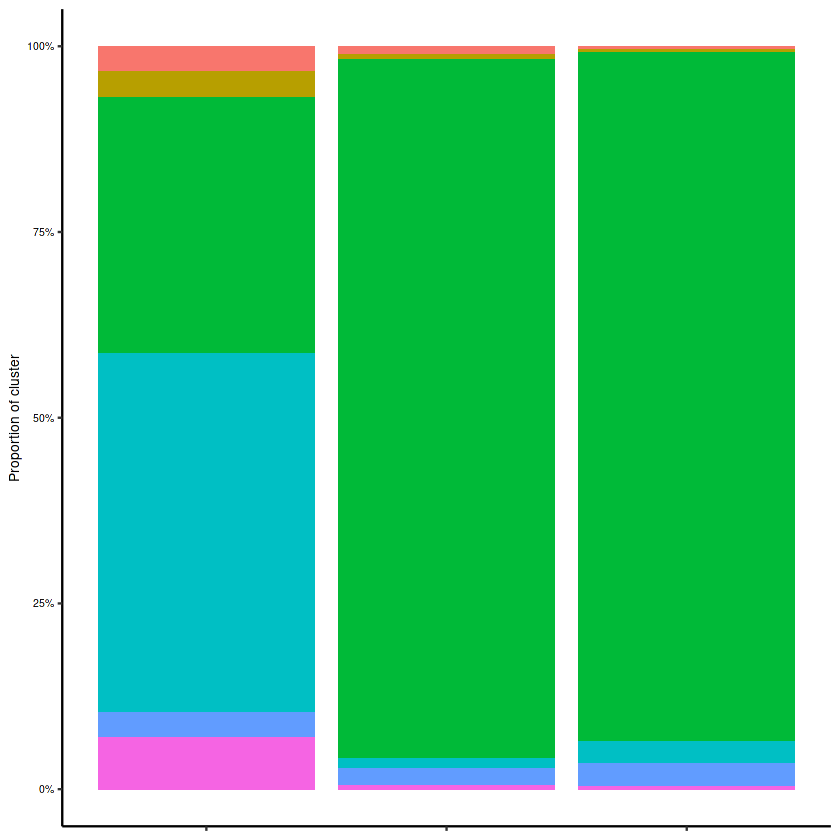

In [20]:
#Figure 2F: Plot bar graph for cluster distribution (2nd resp., TP3 vs TP8)

#Input layer
dir.input <- 'result/intermediate/2_SCT/scTCR_analysis'
dir.output <- "result/Fig2"
cores <- 12 
clusts <- c("X0", "X1", "X2", "X3", "X4", "X5")
groups <- c("Early_TP3", "Main_TP3", "Main_TP8")
red.use <- "wnn.umap"

#################################### Processing layer ####################################################
dir.create(dir.output)

#Summarize cluster distribution of Responder clones
files  <- list.files(dir.input, pattern="clone_within_cluster.bulkinfo")
t<-proc.time()
cl <- makeCluster(cores)
registerDoParallel(cl)   
out <- foreach(file.name = files, .combine = "rbind",
               .packages=c("stringr", "data.table", "dplyr")) %dopar% {Dist_summarize(file.name, dir.input)}
stopCluster(cl)
proc.time()-t
name.output <- str_c(dir.output, "2F_Resp.Distribution.Sep.csv", sep = "/")
write.csv(out, name.output, row.names = F)

data.table <- as.data.frame(out)
#Call sample info
param <- str_split(data.table$file.name, pattern = "\\.", simplify = TRUE)
param <- str_split(param[,1], pattern = "_", simplify = TRUE)
data.table$TP <- param[,1]
data.table$ID <- param[,2]

#Select data for plot
#data.count <- dplyr::select(data.table, starts_with("X"))
#data.table$total <- apply(data.count, 1, sum)
#data.sub <- dplyr::filter(data.table, total >= 10 & class != "Others" & class != "NA")

#Summarize
data.table$key <- str_c(data.table$class, data.table$TP, sep = "_")
table <- dplyr::filter(data.table, key %in% groups) %>% 
            dplyr::group_by(key) %>% dplyr::summarize(dplyr::across(clusts, sum))
#Adjusting tables
data.table <- tidyr::gather(data = table, clusts, key = "clust", value = "Number")
data.table$clust <- str_remove(data.table$clust, "X")
data.table$key <- factor(data.table$key, levels = groups)
names(data.table) <- c("Treat", "clust", "Number")
file.name=str_c(dir.output, "2F.Cluster_dist.2ndresp.tiff", sep = "/")
Cluster_bar(seu, red.use, data.table, dir.output, file.name, 1.6, 1.3)

In [26]:
#Figure 2G: Search DEGs between TP3 2nd_resp vs TP8 2nd_resp

dir.name <- "result/Fig2/2G"
dir.input <- "result/intermediate/2_SCT/scTCR_analysis" #Directory for clone table of scTCR
pattern <- "Main"
Subset1 <- "TP3"
Subset2 <- "TP8"
gene.specify <- c("ITGAX", "IFNGR1",
                  "TYMS", "MCM4",
                  "CD28", "ICOS", "CD24",
                  "BACH2", "STAT3",
                  "KIR2DL1", "CCR9", "BTLA",
                  "IL23R", "CD274")

##################### Processing layer #############################################################
dir.create(dir.name)

#Load meta data
meta.data <- as.data.frame(seu@meta.data)
tmp_raw <- as.vector(row.names(meta.data))

sct.names <- list.files(dir.input, "bulkinfo.csv")

data_Resp <- data.frame()
data_RespInc <- data.frame()
TPs <- unique(meta.data$TP)

#Extract cells in 2nd responder at TP3 and TP8, EM cluster
data_Resp_all <- data.frame()
for(TP in TPs){
    sct.names.sub <- sct.names[str_detect(sct.names, TP)]
    data_Resp <- data.frame()
    for(sct.name in sct.names.sub){
        #Call clone table
        clone_within_cluster <- read.csv(str_c(dir.input, sct.name, sep = "/"), header = TRUE)
        Sample <- str_split(sct.name, pattern = "\\.", simplify = TRUE)[1]
        ##For Responder only
        #Extract cells belonging to the clone in search
        clone_plot <- dplyr::filter(clone_within_cluster, Resp == pattern)
        clone_names <- clone_plot$names
        #Extract cell names for Dimplot/Pie chart
        data_sub <- dplyr::filter(meta.data, clone.id.TCRb %in% clone_names & orig.ident == Sample & seurat_clusters == 2)
        data_Resp <- rbind(data_Resp, data_sub)
    }
    data_Resp$key <- str_c(pattern, TP, sep = "_")
    data_Resp_all <- rbind(data_Resp_all, data_Resp)
}

#Substitute TP3 or TP8 2nd resp. for "ident"
data_Resp <- dplyr::select(data_Resp_all, "key")
data_Resp$CellID <- row.names(data_Resp)
meta.data$CellID <- row.names(meta.data)
meta.data <- merge(x=meta.data, y=data_Resp, all.x=TRUE, by ="CellID")
row.names(meta.data) <- meta.data$CellID
seu2 <- seu
ident <- seu2@active.ident 
names.ident <- names(ident)
ident <- as.factor(str_remove(meta.data$key, "Main_"))
names(ident) <- names.ident
seu2@active.ident <- ident

#DEG extracton
DefaultAssay(seu2) <- 'RNA.RPCA'
DEG.subset.1 = FindMarkers(seu2, ident.1 = Subset1, ident.2 = Subset2,
                           test.use="wilcox", only.pos=TRUE, min.pct=0.1,
                           features.use = NULL, nthreads = 12,
                           logfc.threshold = 0)
name.output <- str_c(dir.name, "MainResp", sep = "/") %>% str_c(Subset1, "Up.RNA.csv", sep = ".")
write.csv(DEG.subset.1, name.output, row.names = TRUE)

DEG.subset.2 = FindMarkers(seu2, ident.1 = Subset2, ident.2 = Subset1,
                           test.use="wilcox", only.pos=TRUE, min.pct=0.1,
                           features.use = NULL, nthreads = 12,
                           logfc.threshold = 0)
name.output <- str_c(dir.name, "MainResp", sep = "/") %>% str_c(Subset2, "Up.RNA.csv", sep = ".")
write.csv(DEG.subset.2, name.output, row.names = TRUE)

#Generate volcano plot
DEG.subset.1 <- dplyr::select(DEG.subset.1, c("avg_log2FC", "p_val_adj"))
DEG.subset.2 <- dplyr::select(DEG.subset.2, c("avg_log2FC", "p_val_adj"))
DEG.subset.2$avg_log2FC <- -DEG.subset.2$avg_log2FC
DEGs <- rbind(DEG.subset.1, DEG.subset.2)

#generate Annotations
DEGs$genes <- row.names(DEGs)
DEGs$class <- "UC"
DEGs$class[which(DEGs$p_val_adj < 0.01 & DEGs$avg_log2FC > 1)] <- "Inc"
DEGs$class[which(DEGs$p_val_adj < 0.01 & DEGs$avg_log2FC < -1)] <- "Dec"

"%not.in%" <- Negate("%in%")
DEGs$genes[which(DEGs$genes %not.in% gene.specify)] <- ""

#Plotting
ppi <- 600
name.output <- name.output <- str_c(dir.name, "DEGs.MainResp", sep = "/") %>% str_c(Subset1, "vs", Subset2, "tiff", sep = ".")
tiff(name.output, width=1.8*ppi, height=1.8*ppi, res=ppi)
p <- ggplot(DEGs, aes(x=-avg_log2FC, y=-log10(p_val_adj), colour = class)) + 
    geom_point(size=0.5, shape = 16) + 
    geom_text_repel(aes(label = genes), size = 2, segment.size = 0.2) +
    scale_colour_manual(values=c(Inc="red", Dec="blue", UC="grey"))+
    theme_bw(base_size = 6) +
    theme(
      axis.title.x=element_blank(), axis.title.y=element_blank(),
      axis.text.x = element_text(size = 6, colour = 1, family = "Arial"),
      axis.text.y = element_text(size = 6, colour = 1, family = "Arial"),
      plot.margin= unit(c(0.25, 0.3, 0.25, 0.25), "lines")) +
    guides(colour= "none")
print(p)
dev.off()

Warning message in dir.create(dir.name):
“'result/Fig2/2G' already exists”
Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

In [29]:
#Figure 2H: Violin Plot for gene score between TP3 2nd_resp vs TP8 2nd_resp

dir.name <- "result/Fig2/2H"
sample.name <- "Signature.Violin.tiff"
csv.name <- "result/Fig2/2H_violinplot_pvalue.csv"
dir.input <- "result/intermediate/2_SCT/GeneScoreSource"

##################### Processing layer #############################################################
dir.create(dir.name)

#Extract 2nd responder cells
seu3 <- subset(seu2, idents = c("TP3", "TP8"))
d <- seu3@meta.data

#Generate Violin Plot
Sig_array <- list.files(dir.input, pattern="Sig.") %>%
                str_remove("Sig.") %>% str_replace(".txt", "1")
result.csv <- createEmptyDf(length(Sig_array), 1, colnames = c("pvalue") )

for(k in 1:length(Sig_array)){
    Sig <- Sig_array[k]
    #Violin Plot
    file.name <- str_c(dir.name, Sig, sep='/') %>% str_c(sample.name, sep = ".")
    ppi <- 600
    tiff(file.name, width=0.8*ppi, height=0.75*ppi, res=ppi)
    p <- vlnplot_score_box(obj = seu3, feature = Sig, pt.size = 0) +
      theme(axis.text.x = element_blank()) 
    plot(p)
    dev.off()
    
    ##Calculate p values
    #Select data
    params <- c("TP", Sig)
    d_sub <- dplyr::select(d, params)
    names(d_sub) <- c("TP", "Signature")
    #Perform test
    split.data <- split(d_sub, d_sub$TP)
    d_test <- t.test(split.data[[1]]$Signature, split.data[[2]]$Signature)
    p.value <- as.numeric(d_test$p.value)
    #Keep records
    result.csv[k,1] <- p.value
}

##Add information for pvalue table
result.csv$Signatures <- Sig_array
qobj<- qvalue(p = result.csv$pvalue, lambda=0)
result.csv$qvalue <- qobj$qvalues
#Judge significance
result.csv$signif <- ""
result.csv$signif[which(result.csv$qvalue < 0.05)] <- "*"
result.csv$signif[which(result.csv$qvalue < 0.01)] <- "**"
result.csv$signif[which(result.csv$qvalue < 0.001)] <- "***"
#Output
write.csv(result.csv, csv.name, row.names = FALSE)

Warning message in dir.create(dir.name):
“'result/Fig2/2H' already exists”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(params)

  # Now:
  data %>% select(all_of(params))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


### Figure S2: Single-cell analysis on CD8+ T cells

In [32]:
###Function: Create Scatter and Violin plot for selected genes
##Input: seurat object, gene list
##Output: Scatter plot, Violin plot

Scatter <- function(seu, dir.name, sample.name, red.use, tmps, tmp_names, width, height, cols){
    for (i in 1:length(tmp_names)){
        #Call gene list
        tmp <- tmps[[i]]
        tmp_name <- tmp_names[i]
  
        #Violin Plot
        file.name <- str_c(dir.name, sample.name, sep='/') %>% str_c("Scatter", tmp_name, "png", sep='.')
        ppi <- 600
        tiff(file.name, width=width*ppi, height=height*ppi, res=ppi)
        p <- FeaturePlot(seu, features = tmps, ncol = cols, order = TRUE,
                        reduction = red.use, dims=c(1,2), cols = c("grey", "red"), pt.size = 0.1) *
                theme(axis.title.x = element_blank(), 
                        axis.title.y = element_blank(),
                        axis.text.x = element_blank(), 
                        axis.text.y = element_blank(),
                        plot.title= element_text(size=12, family = "Arial"),
                       panel.border = element_rect(fill = NA, size = 2)) * 
                theme(legend.position = 'none')
        plot(p)
        dev.off()
    }
}

In [33]:
##Calculate clonality of TCR repertoire in each cluster
Clonality <- function(dir.input, file.name){
  name.input <- str_c(dir.input, file.name, sep = "/")
  d <- read.table(name.input, header = TRUE)
  clust.array <- names(dplyr::select(d, contains("X")))
  output <- data.frame()
  for(i in 1:length(clust.array)){
    clust <- clust.array[i]
    d_sub <- select(d, clust)
    names(d_sub) <- "count"
    d_sub <- filter(d_sub, count > 0)
    d_sub$freq <- d_sub$count / sum(d_sub$count)
    
    ##Calculate median and count clonotypes
    l <- length(d_sub$freq)
    count <- sum(d_sub$count)
    
    #Calculate 1-Pielou clonality
    e <- log(d_sub$freq)
    pi <- 1+sum(d_sub$freq * e)/log(length(d_sub$freq))
    
    out <- c(l, count, pi)
    
    output <- rbind(output, out)
  }
  names(output) <- c("clones", "cells", "Pielou")
  output$cluster <- clust.array
  output$ID <- str_split(file.name, pattern = "\\.", simplify = TRUE)[1]
  
  return(output)
}

In [34]:
### Check batch effect between samples

###Input layer
sample.name <- "COVID"
dir.name <- "result/Fig2/S2B"
red.use <- "wnn.umap"

###Batch params
batch.param <- "ID"

########################## Processing layer #############################
dir.create(dir.name, recursive = TRUE)

ID_TP <- str_split(seu@meta.data$orig.ident, pattern = "_", simplify = TRUE)
seu@meta.data$TP <- ID_TP[,1]
seu@meta.data$ID <- ID_TP[,2]
meta.data <- as.data.frame(seu@meta.data)
tmp_raw <- as.vector(row.names(meta.data))

meta.data.sub <- dplyr::select(meta.data, c(batch.param, "seurat_clusters"))
names(meta.data.sub) <- c("batch", "seurat_clusters")
Treats <- unique(meta.data.sub$batch)
#Create DimPlot separated by batches
for(treat in Treats){
    #Extract cell names for Dimplot chart
    data_sub <- dplyr::filter(meta.data.sub, batch == treat)
    clone.id <- as.vector(row.names(data_sub))
    tmp2 = tmp_raw %in% clone.id
    #Output name
    name.output <- str_c(dir.name, treat, sep = "/") %>% str_c("Dimplot.tiff", sep = ".")
    PlotClones(seu, tmp2, name.output, meta.data, red.use, 2, 2, 0.1)
}

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(batch.param)

  # Now:
  data %>% select(all_of(batch.param))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [35]:
###Check Merker genes for each cluster
sample.name <- "COVID"
dir.name <- "result/Fig2"
red.use <- "wnn.umap"
tmp_rna = c("GNLY", "CD160", "TNF", "TOP2A", "CCR5", "CD38",
            "IL2RA", "TCF7", "PDCD1", "CX3CR1", "PRF1", "ITGAX")
tmp_adt = c("CD56", "CD11c", "CD272", "CD279", "CD27", "HLA-DR",
            "CCR7", "CD127", "CD183", "CD45RA", "Tim3", "CD134")
resol = 0.2

########################## Processing layer #############################
dir.create(dir.name)

###RNA
DefaultAssay(seu) <- 'RNA.RPCA'
##Check lineage marker gene expression
Scatter(seu, dir.name, str_c("S3C.", sample.name, "RNA"), red.use, tmp_rna, "lineage", 5.6, 5, 4)

###ADT
DefaultAssay(seu) <- 'ADT'
##Check lineage marker gene expression
Scatter(seu, dir.name, str_c("S3D.", sample.name, "ADT"), red.use, tmp_adt, "lineage", 5.6, 5, 4)

Warning message in dir.create(dir.name):
“'result/Fig2' already exists”


In [37]:
#FigureS3E: Violin plot for Signature Score

dir.name <- "result/Fig2/S2D"
sample.name <- "S2D.Signature.Violin.tiff"
dir.input <- "result/intermediate/2_SCT/GeneScoreSource"

############################# Processing layer ######################################
dir.create(dir.name, recursive = TRUE)

Sig_array <- list.files(dir.input, pattern="Sig.") %>%
                str_remove("Sig.") %>% str_replace(".txt", "1")
for(Sig in Sig_array){
    #Violin Plot
    file.name <- str_c(dir.name, Sig, sep='/') %>% str_c(sample.name, sep = ".")
    ppi <- 600
    tiff(file.name, width=1.1*ppi, height=0.9*ppi, res=ppi)
    p <- vlnplot_score_box(obj = seu, feature = Sig, pt.size = 0)
    plot(p)
    dev.off()
}

In [38]:
###Generate heatmap of gene scores of clusters

#Specify clone table merged with dLN overlap status
dir.name <- "result/Fig2"
#Specify clone table merged with dLN overlap status
sample.name <- "S2E.Signature.Heatmap.tiff"

############################# Processing layer ######################################
#generate table for plotting
score.table <- dplyr::group_by(seu@meta.data, seurat_clusters) %>%
                dplyr::summarize(dplyr::across(Sig_array, median))
score.table.plot <- t(scale(as.matrix(dplyr::select(score.table, -c("seurat_clusters")))))
colnames(score.table.plot) <- as.vector(score.table$seurat_clusters)
rownames(score.table.plot) <- str_remove(rownames(score.table.plot), "1")

#書き出し
image.file <- str_c(dir.name, sample.name, sep = "/")
  
col_fun = colorRamp2(c(-1, -0.5, 0, 0.5, 1), c("blue","cyan","white","magenta", "red"))
  
#Output
ppi <- 600
tiff(image.file, width=3.3*ppi, height=2.5*ppi, res=ppi)
  
p <- Heatmap(score.table.plot, name = " ", col = col_fun,
               row_names_gp = gpar(fontsize = 8, family="Arial"),
               column_names_gp = gpar(fontsize = 8, family="Arial"),
               column_names_rot = 0,
               row_dend_width = unit(0.5, "cm"),
               column_dend_height = unit(0.5, "cm"),
               heatmap_legend_param =list(labels_gp = gpar(fontsize=6, family="Arial"),
                                          title = "Z value of median Signature Score", 
                                          title_gp = gpar(fontsize=6, family="Arial"),
                                          legend_direction = "horizontal",
                                         legend_width = unit(3, "cm"),
                                         legend_height = unit(0.3, "cm")))
plot(p, heatmap_legend_side = "bottom")
dev.off()

Warning message:
“There was 1 warning in `dplyr::summarize()`.
ℹ In argument: `dplyr::across(Sig_array, median)`.
Caused by warning:
! Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(Sig_array)

  # Now:
  data %>% select(all_of(Sig_array))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


png 
  2

In [39]:
###Calculate clonality of TCR repertoire per clusters

#Input layer
dir.input <- "result/intermediate/2_SCT/scTCR_analysis"
dir.output <- "result/Fig2"
cores = 12

############################# Processing layer ######################################
##Main module
dir.create(dir.output)
files <- list.files(dir.input, pattern = "clone_within_cluster.txt")

t<-proc.time()
cl <- makeCluster(cores)
registerDoParallel(cl)   
out <- foreach(file.name = files,
               .combine = rbind, .packages=c("stringr", "dplyr")) %dopar% {Clonality(dir.input, file.name)}
stopCluster(cl)
proc.time()-t

name.output <- str_c(dir.output, "S2F_Clonality_inCluster.csv", sep = "/")
write.csv(out, name.output, row.names = F)

Warning message in dir.create(dir.output):
“'result/Fig2' already exists”


   user  system elapsed 
  0.015   0.020   1.609 